In [1]:
import jieba
import jieba.posseg as pseg
import re
import gensim
import pandas as pd
from tqdm import tqdm
from collections import Counter
import numpy as np
from gensim import corpora, models
import matplotlib.pyplot as plt
import pyLDAvis.gensim_models
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False

In [2]:
##数据过滤
def DataFilter(line):
    res = re.sub('[^\u4e00-\u9fff\！\。\，\？]+','',line)
    return res
# 分词 保留所有名词类的词（普通名词、人名、地名、机构名、作品名、专名、名动词、名形词）
def fenci(line):
    res = []
    words = pseg.cut(line)
    for word, flag in words:
        if 'n' in flag: 
            res.append(word)
    return res
def remove_stopwords(word_list,stopwords):
    res = []
    for item in word_list:
        if item not in stopwords and len(str(item).strip())>1:
            res.append(item)
    return res

In [3]:
# 加载停用词
with open("./data/hit_stopwords.txt", "r", encoding="utf-8") as f:
    stopwords = [item.strip() for item in f.readlines()]

In [7]:
# 加载文件
df = pd.read_excel('./data/data.xlsx',header=None)
df.head()

,0
0,在义乌众多美食当中，不算出众的团购的卷，还算优惠，菜品还行吧环境可能是个噱头，但位置也不太容...
1,在义乌青年广场二楼，很好找，有泡泡屋、天幕、帐篷等多种形式的位置可选「现烤安格斯牛肉」好好吃...
2,义乌小商品世界，地方有点难找，青年广场进去再出来，二楼大露台，搞的一个露天的帐篷烧烤。做进去...
3,这家店在义乌小商品市场的二楼，根据导航位置很好找。可能是周末去的原因，去的时候都快没座了，团...
4,「手撕鸡」奥尔良口味，鸡肉很嫩，沾水味道很特别。「炸土豆」炸洋芋的调味和云南吃的一样，腐乳加...


In [8]:
# 取出评论内容
texts = df[0].tolist()

In [9]:
# 文本数量
len(texts)

13428

In [10]:
# 文本过滤
fliter_texts = [remove_stopwords(fenci(DataFilter(str(item))),stopwords) for item in texts]

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\Administrator\AppData\Local\Temp\jieba.cache
Loading model cost 0.744 seconds.
Prefix dict has been built successfully.


In [11]:
# 前50个高频词
all_words = []
for item in fliter_texts:
    all_words += item
Counter(all_words).most_common(50)

[('环境', 4842),
 ('服务', 4705),
 ('味道', 3350),
 ('感觉', 2482),
 ('口味', 2277),
 ('有点', 2126),
 ('朋友', 1996),
 ('菜品', 1651),
 ('地方', 1573),
 ('套餐', 1495),
 ('老板', 1472),
 ('服务员', 1444),
 ('新鲜', 1438),
 ('体验', 1321),
 ('价格', 1198),
 ('薄荷', 1063),
 ('食材', 1029),
 ('热情', 1012),
 ('火锅', 958),
 ('活动', 916),
 ('大家', 869),
 ('店里', 831),
 ('蔬菜', 818),
 ('总体', 800),
 ('锅底', 782),
 ('上菜', 756),
 ('羊肉串', 732),
 ('氛围', 723),
 ('性价比', 705),
 ('公司', 698),
 ('孩子', 695),
 ('整体', 694),
 ('口感', 687),
 ('牛肉', 671),
 ('羊肉', 667),
 ('小朋友', 659),
 ('小姐姐', 648),
 ('南京', 635),
 ('设施', 631),
 ('东西', 617),
 ('个人', 609),
 ('聚会', 590),
 ('建议', 584),
 ('特色', 577),
 ('烤串', 574),
 ('草莓', 567),
 ('排队', 556),
 ('钓鱼', 546),
 ('服务态度', 533),
 ('帐篷', 530)]

In [12]:
# 保存词频
cipin = {'词汇':list(dict(Counter(all_words)).keys()),'词频':list(dict(Counter(all_words)).values())}
pd.DataFrame(cipin).to_excel('词频分布.xlsx',index=0)

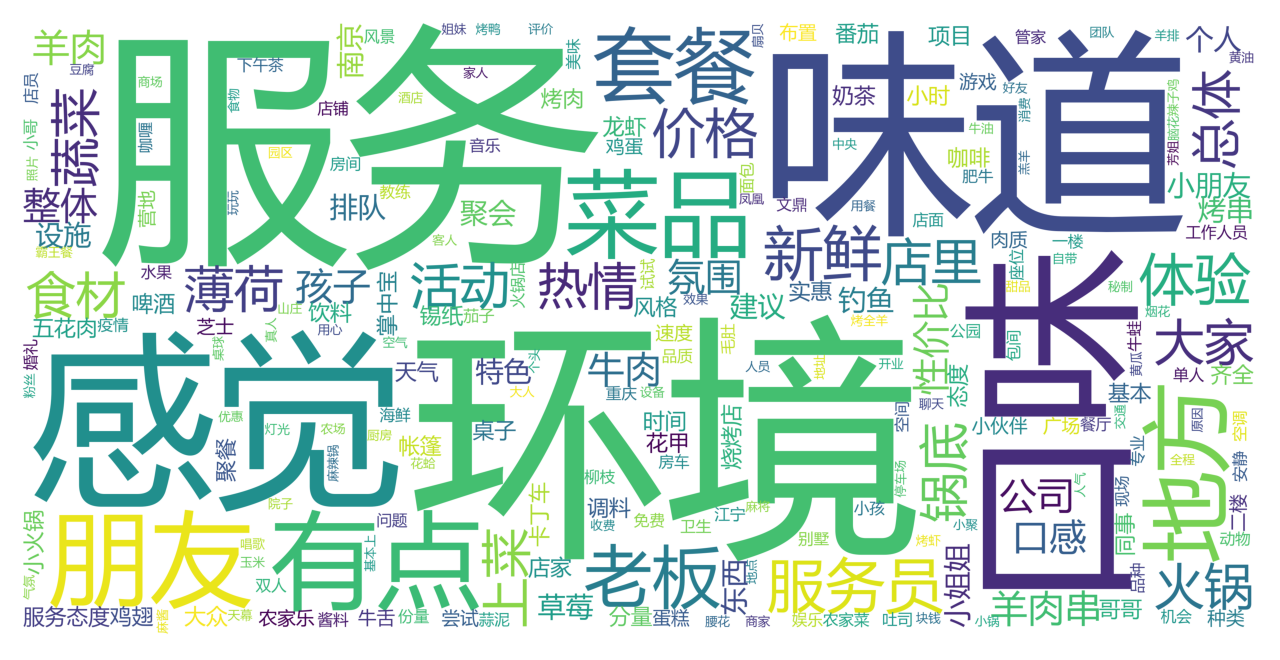

In [13]:
# 高频词云
import matplotlib.pyplot as plt
from wordcloud import WordCloud
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
word_dict = dict(Counter(all_words).most_common(5000))
# 绘制词云
wordcloud = WordCloud(font_path="msyh.ttc",
                      max_words=5000,
                      background_color='white',
                      scale=10
                      )
wordcloud_ = wordcloud.fit_words(word_dict)
plt.figure(figsize=(8, 6), dpi=200)  # 设置画布大小
plt.imshow(wordcloud_)
plt.axis('off')
plt.savefig('./结果/高频词词云.jpg')
plt.show()

In [14]:
dictionary = corpora.Dictionary(fliter_texts)  # 构建 document-term matrix
corpus = [dictionary.doc2bow(text) for text in fliter_texts] #构建语料库
# 计算各个主题分类方法的一致性与迷惑度曲线
perplexity_values = []
model_list = []
# 计算从1到15个主题数量的主题模型 对应的一致性与困惑度
print("正在计算一致性与困惑度")
perplexity_values = [] # 用于困惑度
coherence_values = []  # 用于一致性
model_list = []
topic_numbers_max = 15
topic_numbers_compute  = topic_numbers_max+1
for topic in tqdm(range(1, topic_numbers_compute)):
    #LDA模型训练
    lda_model = gensim.models.LdaMulticore(corpus=corpus, num_topics=topic, id2word=dictionary,
                                           random_state=66, passes=10, workers=3, per_word_topics=30)
    #得到困惑度
    perplexity = lda_model.log_perplexity(corpus)
    #保留三位小数
    perplexity_values.append(round(perplexity, 3))
    #保存一致性
    coherencemodel = models.CoherenceModel(model=lda_model, texts=fliter_texts, dictionary=dictionary, coherence='c_v')
    coherence_values.append(coherencemodel.get_coherence())
    #保存当前模型
    model_list.append(lda_model)


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

正在计算一致性与困惑度


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [09:14<00:00, 36.96s/it]


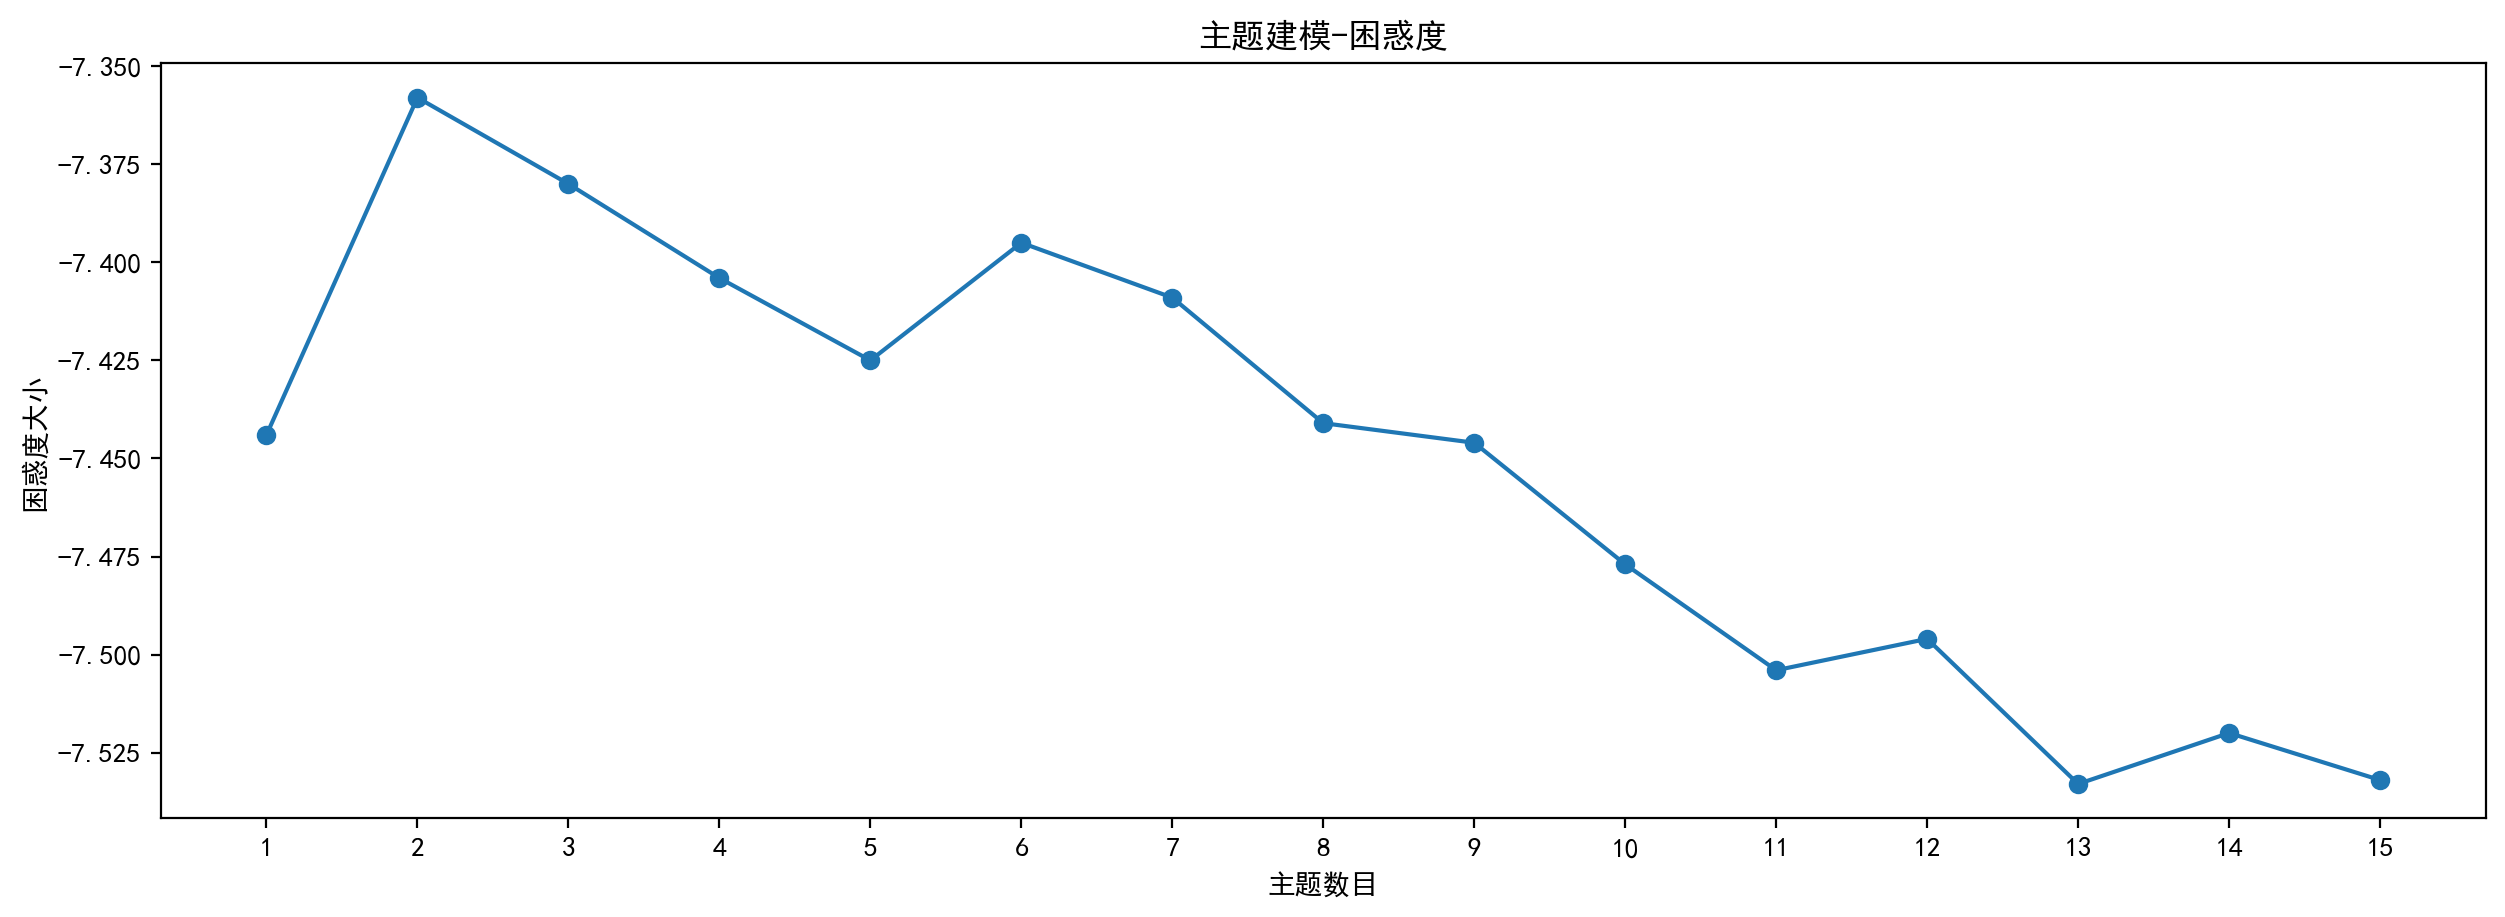

In [15]:
#绘制结果曲线
x = [i for i in range(1,topic_numbers_compute)]
plt.figure(figsize=(15, 5),dpi=200)
plt.plot(x, perplexity_values, marker="o")
plt.title("主题建模-困惑度")
plt.xlabel('主题数目')
plt.ylabel('困惑度大小')
plt.xticks(np.linspace(1, topic_numbers_max,  topic_numbers_max, endpoint=True))  # 保证x轴刻度为1
plt.savefig('./结果/困惑度.jpg')
plt.show()

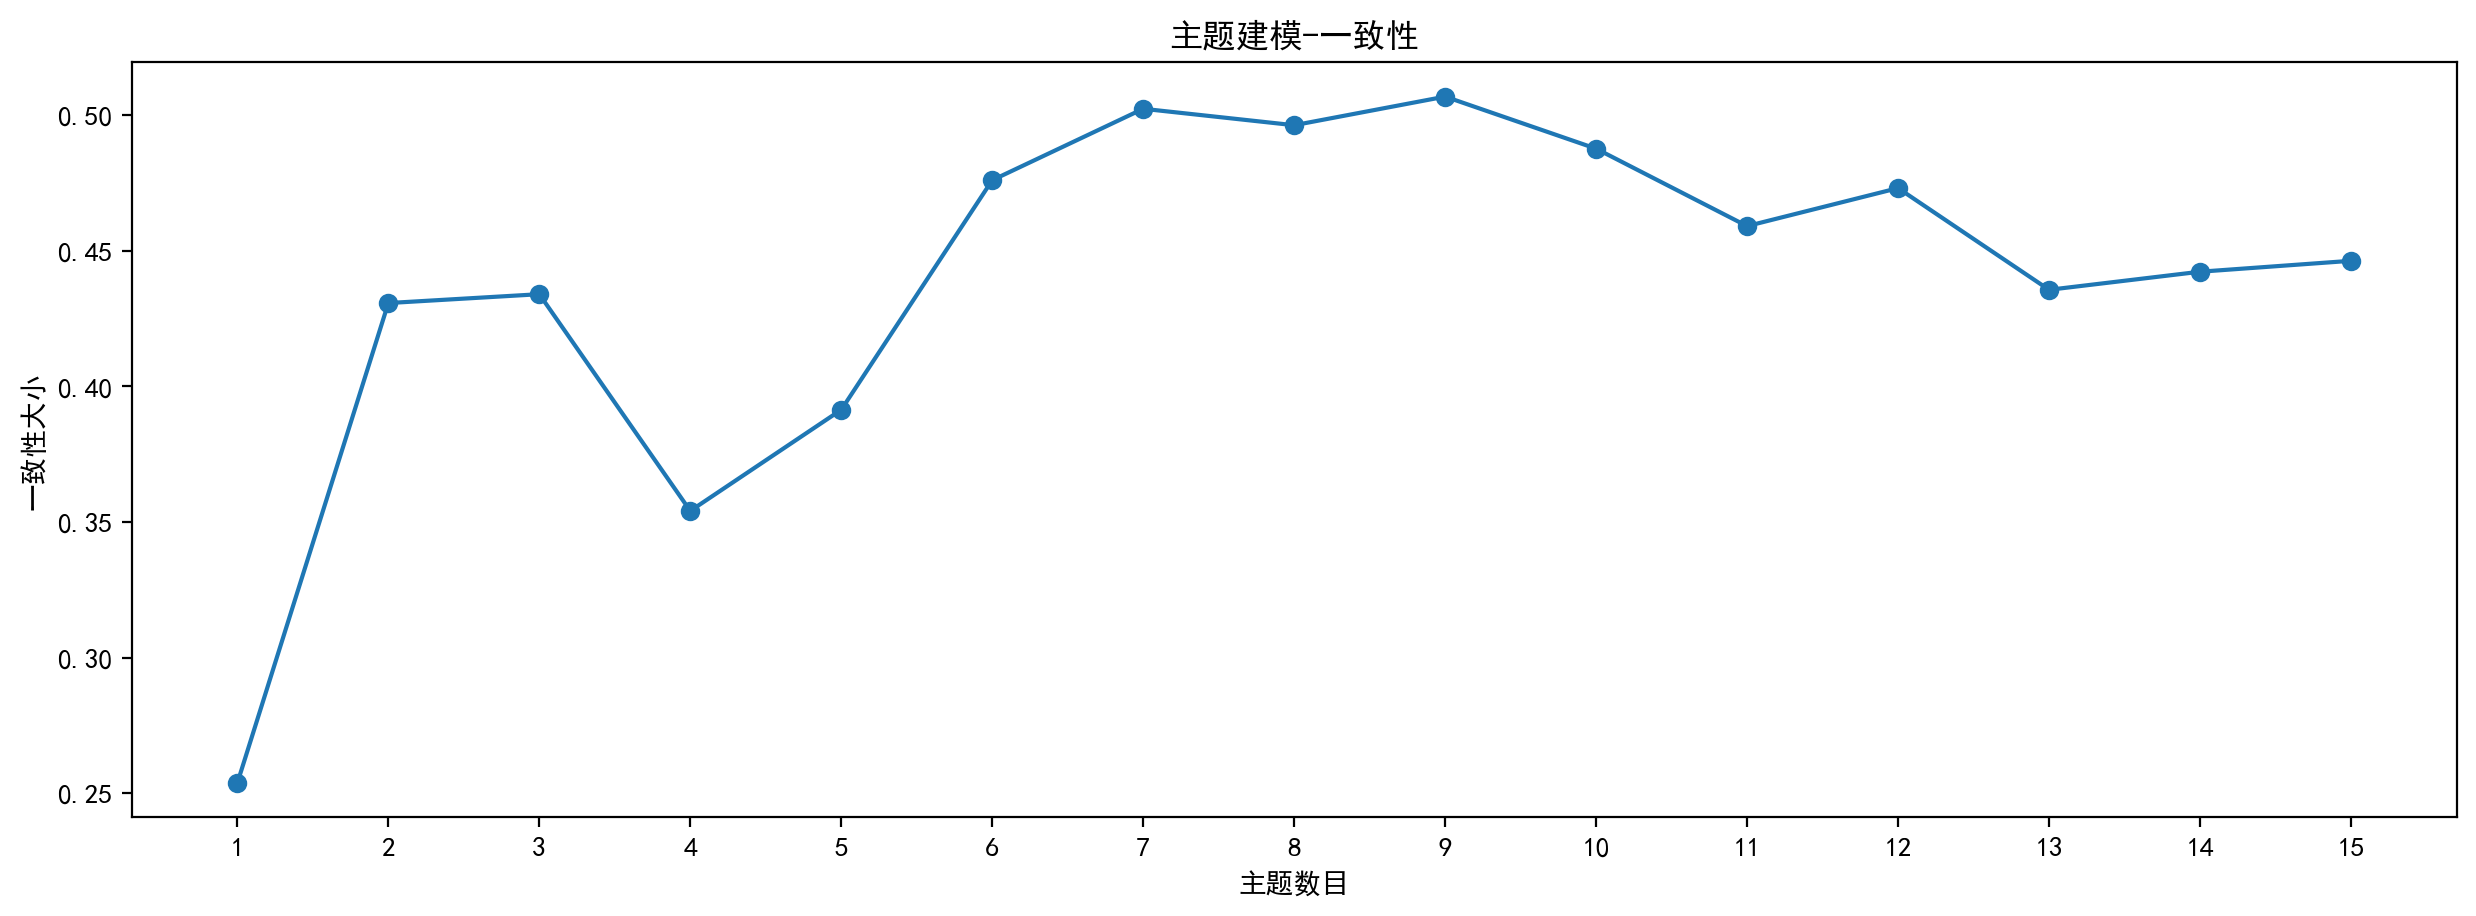

In [16]:
plt.figure(figsize=(15, 5),dpi=200)
plt.plot(x, coherence_values, marker="o")
plt.title("主题建模-一致性")
plt.xlabel("主题数目")
plt.ylabel("一致性大小")
plt.xticks(np.linspace(1,  topic_numbers_max,  topic_numbers_max, endpoint=True))
plt.savefig('./结果/一致性.jpg')
plt.show()

In [22]:
#根据困惑度与一致性分析结果选择主题数量
# 困惑度越低越好，一致性愈高越好  这俩都是随着主题数量正向变化  但是主题数量也不能无限大  所以要在主题量，困惑度 一致性之间平衡
#选择主题数量 对应的主题模型
topic_result = []
topic_num = 3
#选主题词数量
#输出主题词汇概率分布
lda_model_select = model_list[topic_num - 1]
for i in range(0, topic_num):
    temp = lda_model_select.print_topic(i, 30)
    topic_result.append(temp.split('+'))
print('主题：')
for item in topic_result:
    print(item)

主题：
['0.040*"服务" ', ' 0.035*"环境" ', ' 0.026*"味道" ', ' 0.017*"口味" ', ' 0.014*"感觉" ', ' 0.012*"有点" ', ' 0.012*"朋友" ', ' 0.011*"菜品" ', ' 0.011*"薄荷" ', ' 0.011*"下午茶" ', ' 0.010*"服务员" ', ' 0.009*"新鲜" ', ' 0.008*"套餐" ', ' 0.008*"羊肉串" ', ' 0.007*"口感" ', ' 0.006*"店里" ', ' 0.006*"热情" ', ' 0.006*"上菜" ', ' 0.005*"烤串" ', ' 0.005*"酒店" ', ' 0.005*"氛围" ', ' 0.005*"五花肉" ', ' 0.005*"羊肉" ', ' 0.005*"咖啡" ', ' 0.005*"小姐姐" ', ' 0.004*"整体" ', ' 0.004*"价格" ', ' 0.004*"排队" ', ' 0.004*"大堂" ', ' 0.004*"啤酒"']
['0.022*"环境" ', ' 0.018*"老板" ', ' 0.014*"服务" ', ' 0.012*"体验" ', ' 0.011*"地方" ', ' 0.010*"朋友" ', ' 0.009*"设施" ', ' 0.009*"公司" ', ' 0.009*"感觉" ', ' 0.008*"钓鱼" ', ' 0.008*"火锅" ', ' 0.008*"大家" ', ' 0.008*"热情" ', ' 0.008*"聚会" ', ' 0.007*"蔬菜" ', ' 0.007*"食材" ', ' 0.007*"价格" ', ' 0.007*"孩子" ', ' 0.007*"活动" ', ' 0.006*"项目" ', ' 0.006*"锅底" ', ' 0.006*"齐全" ', ' 0.006*"娱乐" ', ' 0.006*"眼镜" ', ' 0.006*"套餐" ', ' 0.005*"小朋友" ', ' 0.005*"专业" ', ' 0.005*"新鲜" ', ' 0.005*"哥哥" ', ' 0.005*"房间"']
['0.019*"地方" ', ' 0.014*"有点" ', 

In [23]:
# 保存到excel中
res = {}
for index,words in enumerate(topic_result):
    word = [item.split('*')[1] for item in words]
    gailv = [str(item.split('*')[0]) for item in words]
    res['主题 '+str(index+1)+' 词汇'] = word
    res['主题 '+str(index+1)+' 概率'] = gailv
pd.DataFrame(res).to_excel('./结果/主题分析结果.xlsx')

In [24]:
import pyLDAvis.gensim_models

In [25]:
#pyLDAvis展示
lda_model_select =lda_model_select
vis_data = pyLDAvis.gensim_models.prepare(lda_model_select, corpus, dictionary)
# 保存 pyLDAvis.html
pyLDAvis.save_html(vis_data, './结果/lda.html')

c:\users\administrator\appdata\local\programs\python\python37\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


In [26]:
#打印每篇文档最高概率主题
bz = []
for i in ldamodel.get_document_topics(corpus)[:]:
    a = []
    b = []
    for j in i:
        a.append(j[0])
        b.append(j[1])
        zipped = zip(a, b)
        sort_zipped = sorted(zipped, key=lambda x: (x[1], x[0]), reverse=True)
        result = zip(*sort_zipped)
        x, y = [list(x) for x in result]
    bz.append(x[0]+1)
df['主题类别'] = bz
df.to_excel('./结果/对应主题类别.xlsx',index=0)